# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd
spot_returns = spot_returns_usd
carry_returns = carry_returns_usd

# Settings

In [23]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=None, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

In [7]:
fwd_scale_2 = {k:v for k,v in fwd_scale.items() if k!="USDCNY"}

In [9]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 'NZD1M CMPN Curncy', 
       'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 
       'CNH1M CMPN Curncy', 'SGD1M CMPN Curncy', 'CHF1M CMPN Curncy', 'THB1M CMPN Curncy', 
       'IHN1M CMPN Curncy', 'IRN1M CMPN Curncy', 'MRN1M CMPN Curncy', 'NTN1M CMPN Curncy', 
       'KWN1M CMPN Curncy', 'PPN1M CMPN Curncy']

fwd_data = new_raw_data[fwd].pipe(fill_date, fill_forward=True)
fwd_data.columns = fwd_scale_2.keys()
for c in fwd_scale_2.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_2[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_2.keys()] + fwd_data

In [12]:
rx = np.log10(fwd_price_ori.pipe(standardize_series, "prices").shift(1)) - np.log10(spot_price_ori[fwd_price_ori.keys()].pipe(standardize_series, "prices"))

In [13]:
rx2 = rx**2

In [14]:
rxi = rx.index
ai = []
for i in rx.index.strftime('%Y-%m').unique():
  aa = [x for x in rxi if x.strftime("%Y-%m") == i][0]
  ai.append(aa)

In [15]:
rx_mo = rx.groupby(rx.index.strftime('%Y-%m')).mean()
rx_mo.index = ai

In [16]:
pos = (rx.loc[:"2020"] > rx_mo.pipe(fill_date, fill_forward=True).loc[:"2020"]).astype(int)
neg = (rx.loc[:"2020"] <= rx_mo.pipe(fill_date, fill_forward=True).loc[:"2020"]).astype(int)

rvu = (rx2*pos)
rvd = (rx2*neg)

In [17]:
rsv = rvd.groupby(rvu.index.strftime('%Y-%m')).sum() - rvu.groupby(rvu.index.strftime('%Y-%m')).sum()
rsv.index = ai
rsv = rsv.shift(1)
rsv = rsv.pipe(fill_date, fill_forward=True)

In [21]:
sig = rsv.pipe(demean_xs).pipe(cap_helper, 0.00025)

# Signal

In [24]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [25]:
bt_obj = b

In [26]:
get_summary(bt_obj)

Returns   : 0.0468305720638665
Vol       : 0.11429522457111972
SR        : 0.4097334095942598
Max DD    : -29.48
Hit rate  : 0.537
W | N | L : 0.54 | 0.0 | 0.46
W/L Ratio : 1.16


In [27]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,0.8819,0.040731,0.136827,0.068081,1.130051,0.635711,0.202292,-0.332443,-0.9183,-0.147978,0.421929,0.296553,-0.255221,0.401678,0.762505,0.827913,-0.117142,-0.300456
sharpe,0.307182,0.031358,0.079144,0.042721,0.381622,0.185824,0.091929,-0.160758,-0.25662,-0.112955,0.180457,0.153501,-0.130435,0.238011,0.289829,0.218553,-0.093124,-0.430358
dollar_sharpe,0.278472,0.024742,0.071868,0.034518,0.379327,0.157545,0.082296,-0.173554,-0.270174,-0.120465,0.161473,0.146399,-0.137446,0.229387,0.280655,0.20507,-0.097825,-0.43608
trade_sharpe,0.307182,0.031358,0.079144,0.042721,0.381622,0.185824,0.091929,-0.160758,-0.25662,-0.112955,0.180457,0.153501,-0.130435,0.238011,0.289829,0.218553,-0.093124,-0.430358
long_sharpe,-0.219737,0.019578,0.187603,0.119039,0.384008,-0.674641,0.022153,-0.014433,-0.241762,-0.129213,-0.661043,0.14789,-0.059186,-0.089021,-0.915534,-0.130584,-0.235345,-1.066113
short_sharpe,0.389004,0.061731,-0.550583,-0.070094,0.366579,0.281801,0.289522,-0.374267,-0.4974,0.100703,0.590082,0.549586,-0.407794,0.453293,0.474296,0.267673,0.144172,0.026993
sortino,0.177735,0.020014,0.046772,0.026362,0.23856,0.110963,0.056631,-0.096353,-0.104157,-0.067331,0.103699,0.085615,-0.076627,0.143738,0.18759,0.114686,-0.048609,-0.156275
max_drawdown,-7.703642,-5.967759,-9.343755,-3.499144,-11.209357,-11.72768,-8.896343,-11.30923,-17.152547,-7.224725,-7.546932,-6.804023,-9.180599,-5.030234,-7.974116,-9.139723,-4.498183,-5.878426
max_drawdown_start,2011-07-27,2008-11-20,2010-06-07,2009-01-23,2007-07-09,2005-03-18,2005-07-04,2003-05-29,2003-09-02,2008-11-19,2008-12-01,2007-05-23,2008-10-08,2008-08-06,2012-02-03,2008-08-08,2011-10-28,2011-08-11
max_drawdown_end,2011-11-23,2013-09-18,2013-10-25,2011-07-29,2011-11-21,2006-06-28,2007-09-28,2014-11-18,2015-01-15,2012-10-17,2016-04-19,2008-03-24,2014-10-28,2008-10-22,2013-09-03,2008-10-27,2016-12-20,2014-01-20


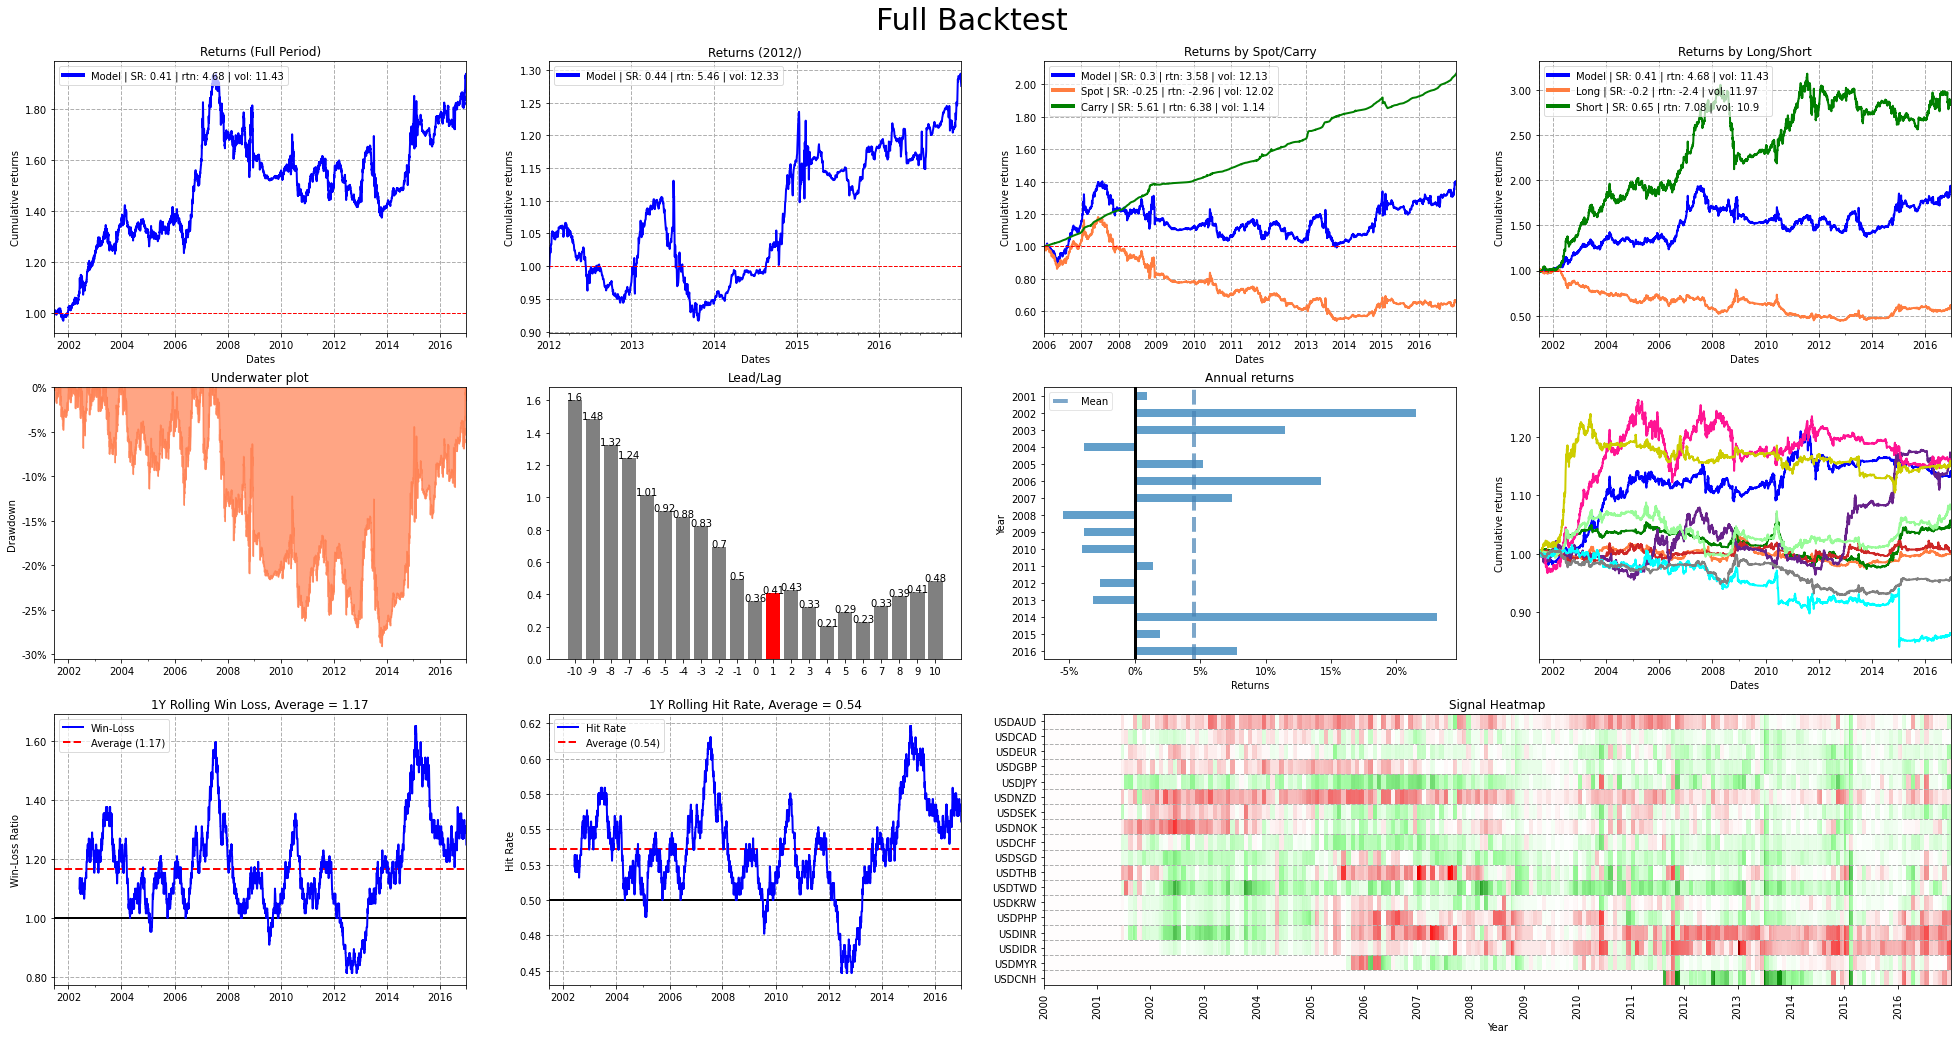

In [30]:
plot_bt(bt_obj)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

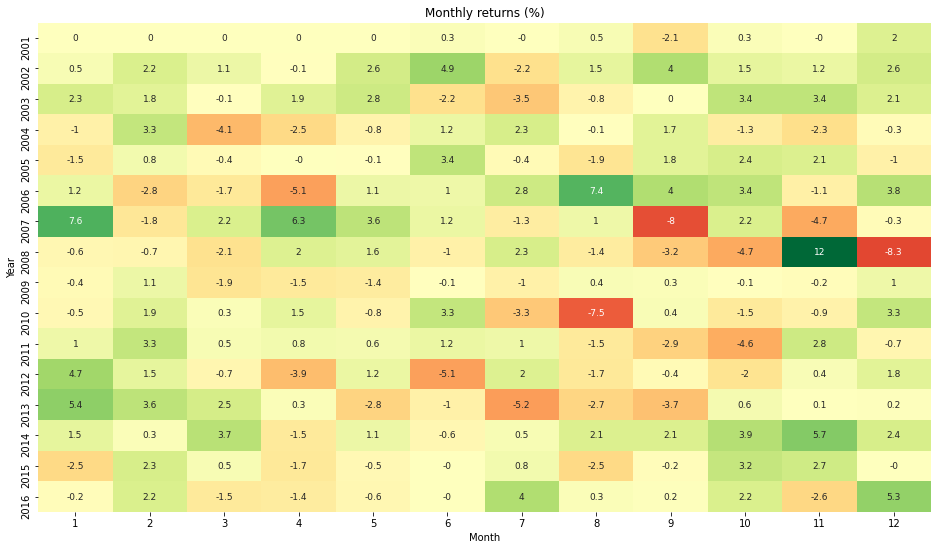

In [31]:
pf.plot_monthly_returns_heatmap(bt_obj.model_rtn)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

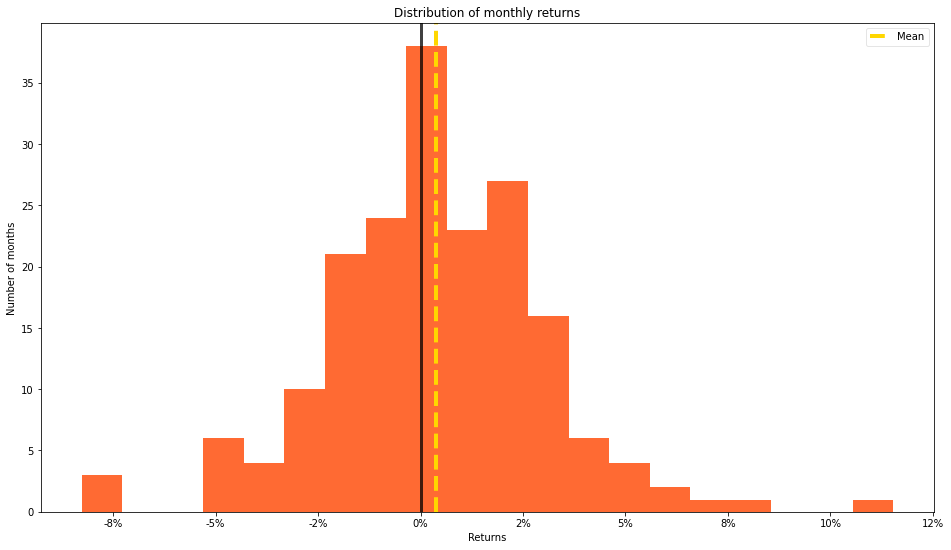

In [32]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)